# Data Input

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm # Note: Do not do import pymc as pm for Version >= 4.0
from tqdm.notebook import tqdm

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [20]:
dic_country = \
{'AUS': 'Australia',
 'BRA': 'Brazil',
 'CAN': 'India',
 'CHN': 'China',
 'GBR': 'United Kingdom',
 'IND': 'India',
 'JPN': 'Japan',
 'SGP': 'Singapore',
 'USA': 'United States'}
pd.DataFrame(dic_country,index=[0]).T.reset_index().rename(columns = {'index': 'country_code', 0: 'country_name'})

,country_code,country_name
0,AUS,Australia
1,BRA,Brazil
2,CAN,India
3,CHN,China
4,GBR,United Kingdom
5,IND,India
6,JPN,Japan
7,SGP,Singapore
8,USA,United States


In [24]:
datas_m_raw = pd.ExcelFile('../../Data/cleaned/Manufacturing_filled.xlsx')
datas_s_raw = pd.ExcelFile('../../Data/cleaned/Service_filled.xlsx')
datas_m = {}
datas_s = {}
for con in dic_country.keys():
    datas_m[con] = pd.read_excel(datas_m_raw, sheet_name=con)
    datas_s[con] = pd.read_excel(datas_s_raw, sheet_name=con)

In [25]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

# Single time series

The model we'll fit, for now, will just be

$$\text{Percentage of value added} \sim \alpha + \beta\ \text{time}$$

First, let's try using the default priors set by prophet, and we'll do a prior predictive check:

In [26]:
data = datas_m['IND']

In [31]:
t = (data["Year"] - 1900).to_numpy()
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)

y = data["Manufacturing_value added_%_of_GDP"].to_numpy()
y_max = np.max(y)
y = y / y_max

Sampling: [likelihood, α, β, σ]


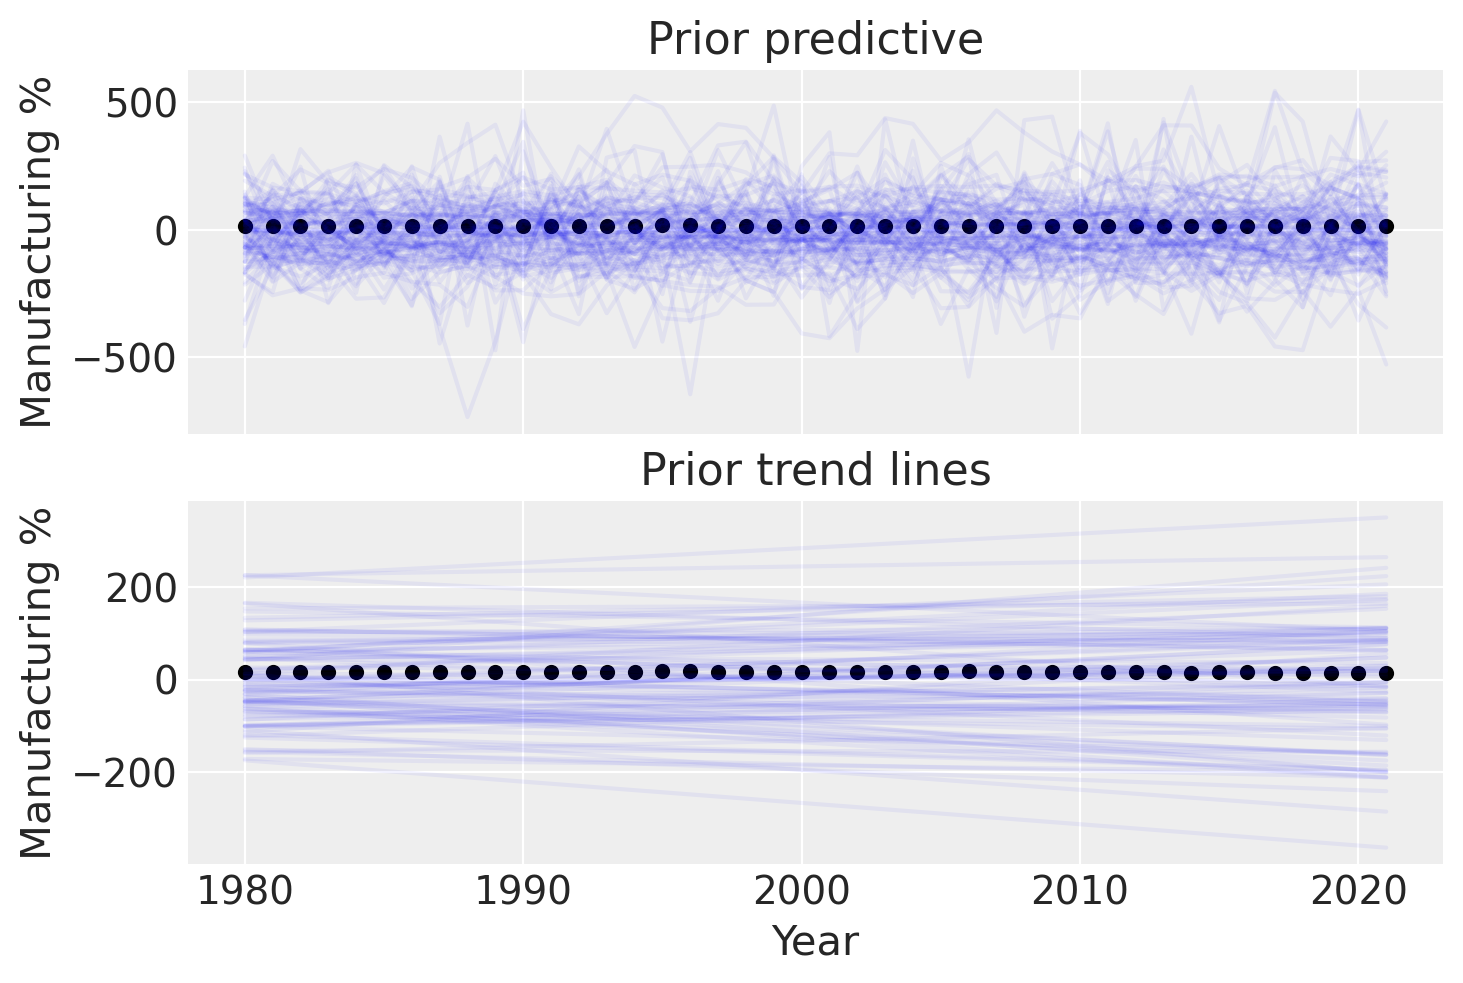

In [32]:
# Generate model with default prophet setting
with pm.Model(check_bounds=False) as linear:
    α = pm.Normal("α", mu=0, sigma=5)
    β = pm.Normal("β", mu=0, sigma=5)
    σ = pm.HalfNormal("σ", sigma=5)
    trend = pm.Deterministic("trend", α + β * t)
    pm.Normal("likelihood", mu=trend, sigma=σ, observed=y)
    linear_prior = pm.sample_prior_predictive()
    
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    data["Year"],
    az.extract(linear_prior, group="prior_predictive", num_samples=100)["likelihood"]
    * y_max,
    color="blue",
    alpha=0.05,
)
data.plot.scatter(x="Year", y="Manufacturing_value added_%_of_GDP", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")
ax[0].set_ylabel("Manufacturing %")

ax[1].plot(
    data["Year"],
    az.extract(linear_prior, group="prior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.05,
)
data.plot.scatter(x="Year", y="Manufacturing_value added_%_of_GDP", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines");
ax[1].set_ylabel("Manufacturing %")
plt.show()

We can do better than this. These priors are evidently too wide, as we end up with implausibly % higher than 100 / below 0, suggesting setting tighter priors.

Sampling: [likelihood, α, β, σ]


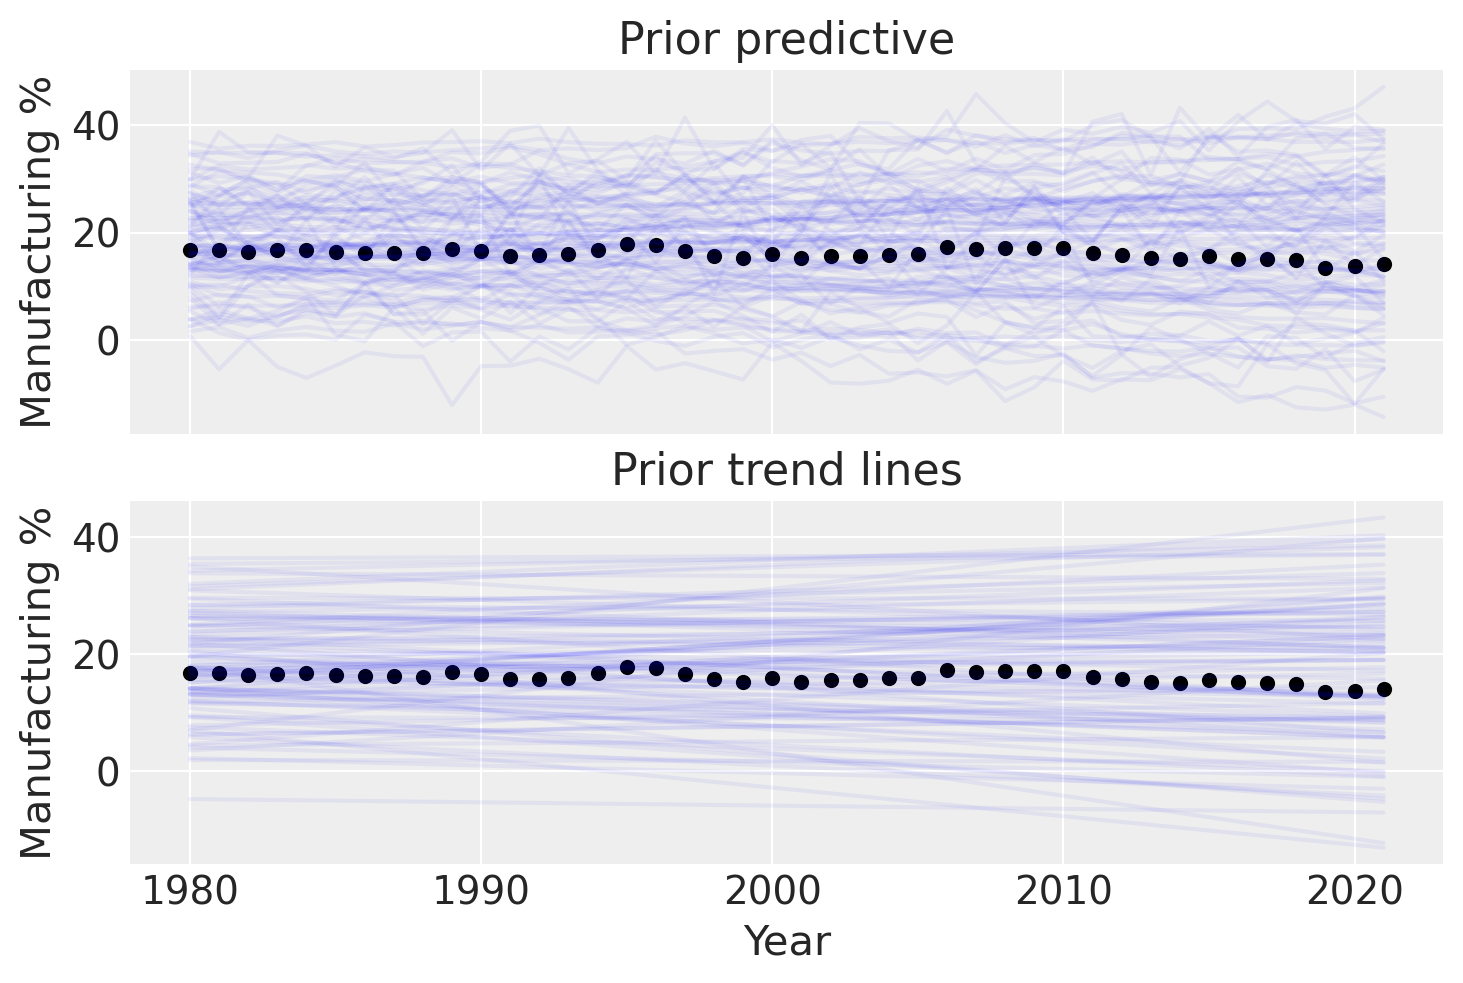

In [33]:
with pm.Model(check_bounds=False) as linear:
    α = pm.Normal("α", mu=1, sigma=0.5)
    β = pm.Normal("β", mu=0, sigma=0.5)
    σ = pm.HalfNormal("σ", sigma=0.1)
    trend = pm.Deterministic("trend", α + β * t)
    pm.Normal("likelihood", mu=trend, sigma=σ, observed=y)

    linear_prior = pm.sample_prior_predictive(samples=100)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    data["Year"],
    az.extract(linear_prior, group="prior_predictive", num_samples=100)["likelihood"]
    * y_max,
    color="blue",
    alpha=0.05,
)
data.plot.scatter(x="Year", y="Manufacturing_value added_%_of_GDP", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")
ax[0].set_ylabel("Manufacturing %")

ax[1].plot(
    data["Year"],
    az.extract(linear_prior, group="prior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.05,
)
data.plot.scatter(x="Year", y="Manufacturing_value added_%_of_GDP", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines")
ax[1].set_ylabel("Manufacturing %")
plt.show()

Cool. Before going on to anything more complicated, let's try conditioning on the data and doing a posterior predictive check:

In [34]:
with linear:
    linear_trace = pm.sample(return_inferencedata=True)
    linear_prior = pm.sample_posterior_predictive(trace=linear_trace)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [likelihood]


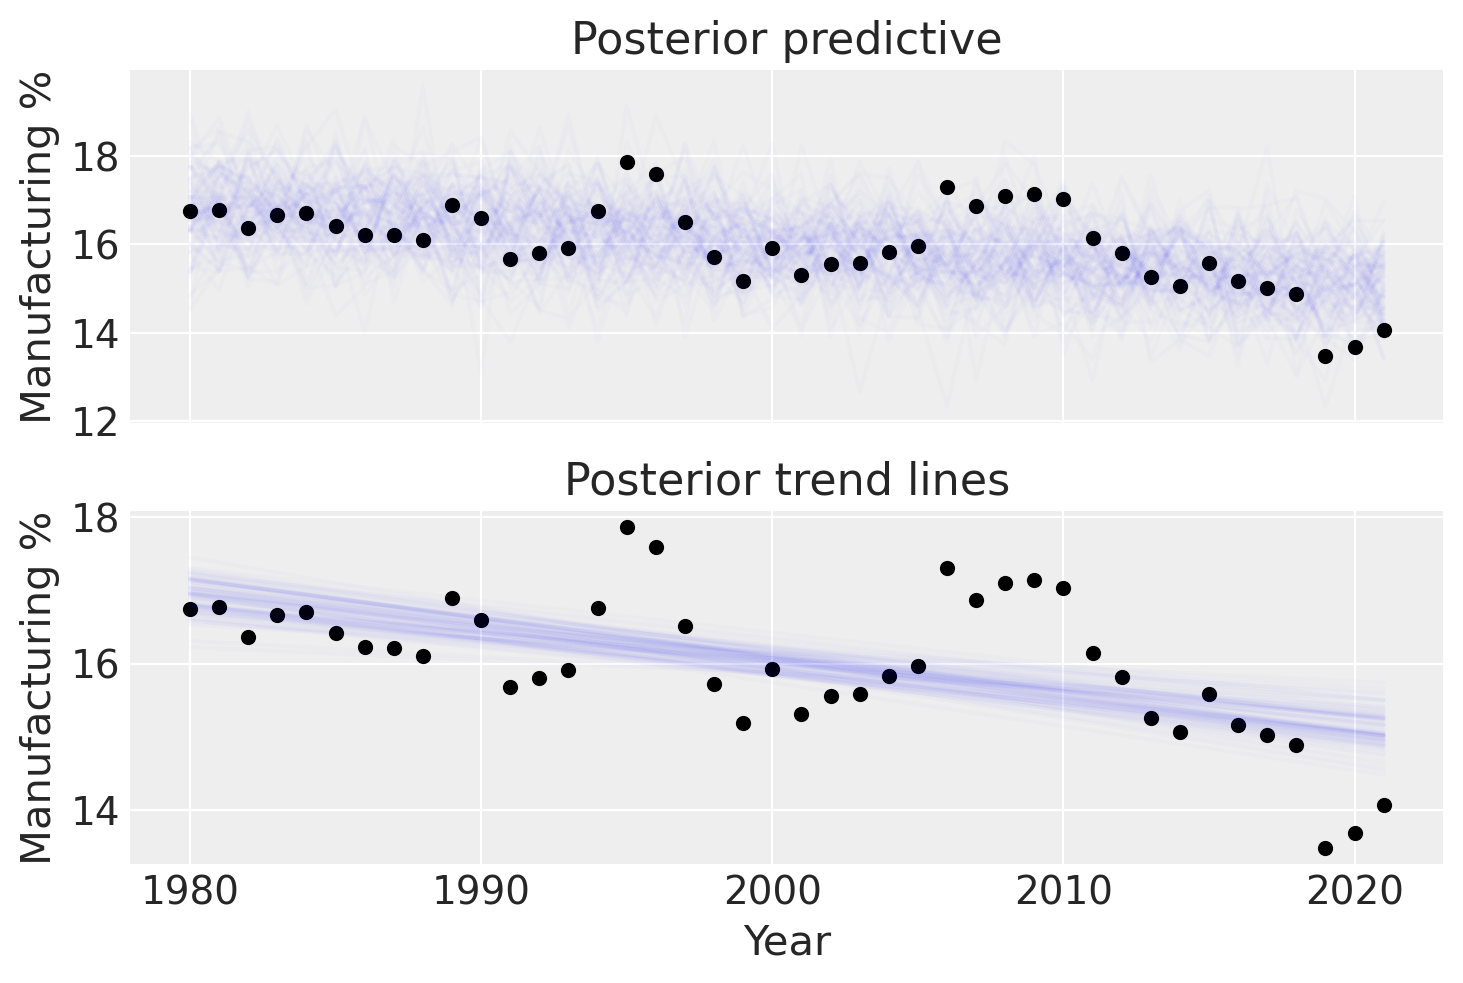

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    data["Year"],
    az.extract(linear_prior, group="posterior_predictive", num_samples=100)["likelihood"]
    * y_max,
    color="blue",
    alpha=0.01,
)
data.plot.scatter(x="Year", y="Manufacturing_value added_%_of_GDP", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")
ax[0].set_ylabel("Manufacturing %")

ax[1].plot(
    data["Year"],
    az.extract(linear_trace, group="posterior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.01,
)
data.plot.scatter(x="Year", y="Manufacturing_value added_%_of_GDP", color="k", ax=ax[1])
ax[1].set_title("Posterior trend lines");
ax[1].set_ylabel("Manufacturing %")
plt.show()


**Notes:**
- Can't utilize seasonality (no proper setting for the fourier series component) for our task: In general, the interval of seasonality is below 1 year.
- Only use the trend term. But in this case `Prophet` packages are better finding the change points.
- Further step: explore more model setting

# Evaluate of all series

In [36]:
results = pd.DataFrame(columns=['task', 'country', 'MAE', 'RMSE', 'MAPE'])

In [37]:
for task, y_label, data_contries in [
    ('Manufacturing', "Manufacturing_value added_%_of_GDP", datas_m),                                 
    ('Service', "Services_value_added_%_of_GDP", datas_s)
]:    
    for con in tqdm(dic_country.keys()):      
        # Construct Dataset
        data = data_contries[con].reset_index()
        
        # Last 5
        # df_train = data[data['Year'] <= 2016]
        # df_test = data[data['Year'] >= 2017]
        df_train = data[:-5]
        df_test = data[-5:]
        y_train = df_train[y_label].to_numpy()
        y_test = df_test[y_label].to_numpy()
        y_train_max = np.max(y_train)
        y_train = y_train / y_train_max

        # Transform data
        t_raw = data["Year"].to_numpy()
        t_min = np.min(t_raw)
        t_max = np.max(t_raw)
        t_all = (t_raw - t_min) / (t_max - t_min)
        t_train = t_all[:len(y_train)]
        t_test = t_all[len(y_train):]

        # Modeling on trainset
        with pm.Model() as linear:
            α = pm.Normal("α", mu=1, sigma=0.5)
            β = pm.Normal("β", mu=0, sigma=0.5)
            σ = pm.HalfNormal("σ", sigma=0.1)
            t = pm.MutableData('t', t_train)

            trend = pm.Deterministic("trend", α + β * t)
            obs = pm.Normal("obs", mu=trend, sigma=σ, observed=y_train, shape=t.shape)
            idata = pm.sample() # MCMC sampling

        # Evaluating on testset
        with linear:
            pm.set_data({"t": t_test})
            ppc_test = pm.sample_posterior_predictive(idata)
        y_pred = ppc_test.posterior_predictive['obs'].mean(('chain', 'draw')).to_numpy() * y_train_max
        mae = MAE(y_test, y_pred)
        rmse = MSE(y_test, y_pred, squared=True)
        mape = MAPE(y_test, y_pred)
        results.loc[len(results.index)] = [task, con, mae, rmse, mape]

  0%|          | 0/9 [00:00<?, ?it/s]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


  0%|          | 0/9 [00:00<?, ?it/s]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [obs]


In [38]:
results.query('country in ["AUS", "BRA", "CAN", "CHN", "GBR"]') \
    .melt(id_vars=['task', 'country'], value_vars=['MAE','RMSE','MAPE'], value_name='Metric') \
    .pivot_table(index=['task'], columns=['country', 'variable'], values=['Metric'])

Metric                                                     \
country             AUS                           BRA                        
variable            MAE      MAPE      RMSE       MAE      MAPE       RMSE   
task                                                                         
Manufacturing  0.332644  0.059038  0.172767  5.386841  0.532275  29.301046   
Service        0.998934  0.015124  1.432020  3.223633  0.052607  14.736744   

                                                                           \
country             CAN                           CHN                       
variable            MAE      MAPE      RMSE       MAE      MAPE      RMSE   
task                                                                        
Manufacturing  2.388897  0.243336  6.445153  1.320865  0.048830  2.034699   
Service        1.220054  0.018153  1.889014  1.528605  0.028505  2.716329   

                                             
country             GBR                      
variable            MAE      MAPE      RMSE  
task                                         
Manufacturing  2.103288  0.238636  4.597650  
Service        0.490092  0.006780  0.626199

In [39]:
results.query('country not in ["AUS", "BRA", "CAN", "CHN", "GBR"]') \
    .melt(id_vars=['task', 'country'], value_vars=['MAE','RMSE','MAPE'], value_name='Metric') \
    .pivot_table(index=['task'], columns=['country', 'variable'], values=['Metric'])

Metric                                                     \
country             IND                           JPN                        
variable            MAE      MAPE      RMSE       MAE      MAPE       RMSE   
task                                                                         
Manufacturing  1.585113  0.113498  2.879326  1.500254  0.074089   2.304835   
Service        1.281263  0.026610  2.215424  4.545097  0.065376  21.224116   

                                                                           
country             SGP                           USA                      
variable            MAE      MAPE      RMSE       MAE      MAPE      RMSE  
task                                                                       
Manufacturing  0.851191  0.043623  1.112736  1.018101  0.090811  1.136948  
Service        0.975051  0.013786  1.223821  0.814880  0.010351  1.198964

**Notes:**
- We need contry-specific prior. It can be better than ARIMA, but worse than prophet
- For service, there are missingness at the latest years:

    <img src="https://cdn.mathpix.com/snip/images/bCSoR3ODczCcBC8xABXqnmAoeFUZsJIbTh-7ovYhuIE.original.fullsize.png" />

    - Not impute: not compared in the same forecasting range
    - Impute: impact on model selection ()
    - Suggestion: test set = last 5 years, prediction range = until 2026